In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import Flow_solutions as FS
import astropy
import tools
import matplotlib.pyplot as plt

# Define all the functions

In [2]:
def get_vs(T,mu):
    """
    Calculates the isothermal sound speed (vs).

    Parameters
    ----------
    T : float
        The temperature of the gas in [K].
    mu : float
        The mean molecular weight in [amu].

    Returns
    -------
    vs : float
        Sound speed in [m/s].
    """
    
    # import constants
    kB = tools.kB
    u_amu = tools.u

    # calculate sound speed
    vs = np.sqrt((T*kB)/(u_amu*mu))

    return vs

def get_rs(Mp,vs):
    """
    Calculates the sonic radius (rs).

    Parameters
    ----------
    Mp : float
        The mass of the planet in [kg].
    vs : float
        The sound speed in [m/s].

    Returns
    -------
    rs : float
        Sonic radius in [m].
    """

    # import constants
    G = tools.G

    # calculate sonic radius
    rs = G*Mp/(2*vs**2)

    return rs


def get_Mdot(vs_wind,rXUV,Mp,sigma_XUV,mu_wind):
    """
    Calculates the mass-loss rate for a given sound speed (i.e., given temperature and mu), XUV cross-section.
    The computed mass-loss rate considers the dynamics of the parker wind (mass continuity) and radiative physics (i.e., optical depth or how the medium interacts with XUV radiation).

    Parameters
    ----------
    vs_wind : float
        The isothermal sound speed in the hydrostatic layer in [m/s].
    rXUV : float
        The radius at which the gas becomes optically thick to XUV radiation, i.e., when the optical depth equals to unity in [m].
    Mp : float
        The mass of the planet in [kg].
    sigma_XUV : float
        The cross-section to XUV radiation in [m^2].
    mu_wind : float
        The mean molecular weight of the wind in [amu].

    Returns
    -------
    Mdot : float
        The calculated mass-loss rate in [kg/s].
    """

    ### import constants
    u_amu = tools.u
    
    ### compute sonic radius of the wind
    # this is the "hot" sonic radius where sonic speed is computed using the isothermal temperature of the outflow, T_wind
    rs_wind = get_rs(Mp,vs_wind) 

    ### define integration domain
    r = np.logspace(np.log10(rXUV),np.log10(max(5*rs_wind,5*rXUV)),250) # np.logspace ensure more calculation near the planet radius

    ### compute velocity profile
    if (rs_wind >= rXUV):
        # RXUV sits inside of the sonic radius
        # gas behaves as a transonic wind, flowing continuously from a slow, subsonic speed to a supersonic speed, after passing the sonic point
        # i.e., critical solution to the Parker wind equations
        v = FS.FlowSolutions.get_parker_wind(r,vs_wind,rs_wind)    
    else:
        # RXUV sits outside of the sonic radius
        # RXUV becomes the launch radius, forcing the gas to start flow at sound speed

        # finding the constnat by imposing v = vs at r = rxuv. The 1e-13 is added to prevent numerical issues when RXUV is very close to rs_wind.
        constant = (1. - 4.*np.log(rXUV/rs_wind) - 4.*(rs_wind/rXUV)-1e-13) 

        v = FS.FlowSolutions.get_parker_wind_const(r,vs_wind,rs_wind,constant)

    ### compute density profile
    # "shape" of the density profile dimensionless
    # derived from mass continuity equation, (rs/r)^2 * (vs/v) = constant
    rho_shape = (rs_wind/r)**2.*(vs_wind/v)
    
    #### compute optical depth tau and set it to unity to solve for density scaling
    ## kappa is assumed constnant thorughout r
    # compute the shape of tau_target. Integrates from large r to small r using [::-1]
    tau_shape = np.abs(np.trapezoid(rho_shape[::-1],r[::-1])) 

    # set optical depth to XUV to unity
    tau_target = 1.0   

    # opacity, from n * sigma_XUV = rho * kappa 
    kappa = sigma_XUV/(mu_wind*u_amu)     
    
    # density at the sonic radius, from equation tau_target = kappa * rho_s * tau_shape
    rho_s = tau_target/(kappa*tau_shape) 

    # density profile as a function of radius
    rho_wind = rho_shape*rho_s 
    

    ### mass-loss rate at r = rXUV, the first element in rho and v arrays
    # computed using mass continuity equation, Mdot = 4 * pi * r^2 * rho_wind * v, at r = rXUV 
    Mdot = 4 * np.pi * rXUV**2 * rho_wind[0] * v[0] 
        
    return Mdot



def Mdot_difference(vs_wind,rXUV,rp,Mp,sigma_XUV,mu_wind,eff,FXUV):
    """
    Computes the difference between the mass-loss rate, calculated from mass continuity and optical depth constraints, and the energy-limited mass-loss rate.

    Parameters
    ----------
    vs_wind : float
        The isothermal sound speed in the hydrostatic layer in [m/s].
    rXUV : float
        The radius at which the gas becomes optically thick to XUV radiation, i.e., when the optical depth equals to unity in [m].
    rp : float
        The radius of the planet in [m].
    Mp : float
        The mass of the planet in [kg].
    sigma_XUV : float
        The cross-section to XUV radiation in [m^2].
    mu_wind : float
        The mean molecular weight of the wind in [amu].
    eff : float
        The efficiency of the energy-limited mass-loss, [unitless].
    FXUV : float
        The XUV flux received by the planet in [W/m^2].

    Returns
    -------
    Mdot_diff : float
        Mass-loss rate difference, [unitless]
    """
    ### import constants
    G = tools.G

    ### Mass loss rate from mass continuity and optical depth constraints
    Mdot_wind = get_Mdot(vs_wind,rXUV,Mp,sigma_XUV,mu_wind)  

    ### EL mass-loss rate
    Mdot_EL = eff*np.pi*rXUV**2*rp*FXUV / (G*Mp)  

    Mdot_diff = (Mdot_wind-Mdot_EL)/(Mdot_EL+1.) 

    return Mdot_diff



def get_vs_wind(rXUV,rp,Mp,sigma_XUV,mu_wind,eff,FXUV):
    """
    Solves for the sound speed such that the mass-loss rate of the outflowing matches the energy-limited mass-loss rate.
    Effectively, this solves for the "temperature" of the isothermal wind, that is, when the thermal push of the atmosphere exactly uses up the energy budget provided by the star's radiation.
    
    Parameters
    ----------
    rXUV : float
        The radius at which the gas becomes optically thick to XUV radiation, i.e., when the optical depth equals to unity in [m].
    rp : float
        The radius of the planet in [m].
    Mp : float
        The mass of the planet in [kg].
    sigma_XUV : float
        The cross-section to XUV radiation in [m^2].
    mu_wind : float
        The mean molecular weight of the wind in [amu].
    eff : float
        The efficiency of the energy-limited mass-loss, [unitless].
    FXUV : float
        The XUV flux received by the planet in [W/m^2].

    Returns
    -------
    vs_wind_sol : float
        The computed sound speed in [m/s].
    """
    
    ### "guessing range" for the sound speed
    # initial lower bound guess
    lower_bound_initial = 2e5 
    # upper bound guess 
    upper_bound = 1e13

    ### function for root finding 
    f1 = Mdot_difference(lower_bound_initial,rXUV,rp,Mp,sigma_XUV,mu_wind,eff,FXUV)   
    
    ### apply Brent's root finding method
    # The function must be continuous, and must have opposite signs, i.e., for the given upper and lower bounds (a and b). f(a) and f(b) must have opposite signs.
    # This way, the root x can be found within the interval [a, b], such that f(x) = 0. 
    if (f1 < 0):   # initial guess captures the root
        vs_wind_sol = brentq(Mdot_difference,lower_bound_initial,upper_bound,args=(rXUV,rp,Mp,sigma_XUV,mu_wind,eff,FXUV))
    else:          # initial guess too high, need to reduce lower bound 
        lower_bound = lower_bound_initial
        while f1 > 0:
            lower_bound = 0.95*lower_bound
            f1 = Mdot_difference(lower_bound,rXUV,rp,Mp,sigma_XUV,mu_wind,eff,FXUV)
        vs_wind_sol = brentq(Mdot_difference,lower_bound,upper_bound/10,args=(rXUV,rp,Mp,sigma_XUV,mu_wind,eff,FXUV))

    return vs_wind_sol


def get_rho_p(rp,Mp,kappa_IR,vs_eq):
    """
    Calculates density of the hydrostatic layer at r = Rp, where rp is the photosphere.

    Parameters
    ----------
    Mp : float
        The mass of the planet in [kg].
    rp : float
        The radius of the planet in [m].
    kappa_IR : float
        The opacity at the photosphere in [m^2/kg].
    vs_eq : float
        The sound speed calculated with the equilibrium temperature in the hydrostatic layer in [m/s].

    Returns
    -------
    rho_p : float
        The density of the hydrostatic layer at r = rp in [kg/m^3].
    """
    
    ### import constants
    G = tools.G

    ### compute density at the hydrostatic layer at r = rp
    rho_p = G*Mp/(rp**2*vs_eq**2*kappa_IR)

    return rho_p


def momentum_difference(rXUV,rho_p,rp,Mp,sigma_XUV,mu_wind,eff,vs_eq,FXUV):
    """
    Compute the densities of two layers (hydrostatic and hydrodynamic) at r = rXUV.
    And use the momumtum conservation to calculate the momentum difference betweem the two layers at r = rXUV.

    Parameters
    ----------
    rXUV : float
        The radius at which the gas becomes optically thick to XUV radiation, i.e., when the optical depth equals to unity in [m].
    rho_p : float
        The density of the hydrostatic layer at r = rp in [kg/m^3].
    rp : float
        The radius of the planet in [m].
    Mp : float
        The mass of the planet in [kg].
    sigma_XUV : float
        The cross-section to XUV radiation in [m^2].
    mu_wind : float
        The mean molecular weight of the wind in [amu].
    eff : float 
        The efficiency of the energy-limited mass-loss, [unitless].
    vs_eq : float
        The sound speed calculated with the equilibrium temperature in the hydrostatic/bolometrically heated layer in [m/s].
    FXUV : float
        The XUV flux received by the planet in [W/m^2].

    Returns
    -------
    momentum_diff : float
        The momentum difference between the hydrostatic layer and hydrodynamic layer at r = rXUV.

    """
    
    ### import constants
    G = tools.G
    

    ### momentum of the hydrostatic layer at r = rXUV
    # density of the hydrostatic layer at r = rXUV.
    rho_XUV_hs = rho_p * np.exp((G*Mp/vs_eq**2.)*(1./rXUV-1/rp))
    # compute sound speed of the hydrodynamic layer (outflowing wind) at r = rXUV.
    vs_wind = get_vs_wind(rXUV,rp,Mp,sigma_XUV,mu_wind,eff,FXUV)
    # momentum_hs
    momentum_hs = rho_XUV_hs * vs_eq**2.


    ### momentum of the hydrodynamic layer at r = rXUV
    # as outflowing wind temperature cannot exceed 1e4 K. (Owen & Schlichting 2024)
    if (vs_wind > 1.2e6):
        vs_wind = 1.2e6
    # mass-loss rate of hydrodynamic at vs_wind_sol
    Mdot = get_Mdot(vs_wind,rXUV,Mp,sigma_XUV,mu_wind)
    # compute sonic radius
    rs = get_rs(Mp,vs_wind) 
    # compute launch velocity at r = rXUV
    if (rXUV <= rs):
        v_launch = FS.FlowSolutions.get_parker_wind_single(rXUV,vs_wind,rs)
    else:
        v_launch = vs_wind #assuming launching at the sound-speed
    # density of hydrodynamic layer at r = rXUV
    rho_XUV_wind = Mdot/(4*np.pi*rXUV**2.*v_launch)
    # momentum_wind
    momentum_wind = rho_XUV_wind * (v_launch**2. + vs_wind**2.)


    ### calculate momentum difference
    momentum_diff = (momentum_hs - momentum_wind)/(2.*momentum_hs) # 2 in denominator for faster root finding

    return momentum_diff


def compute_RXUV(rho_p,rp,Mp,sigma_XUV,mu_wind,eff,vs_eq,FXUV):
    """
    Solves for the rXUV such that momentum of the hydrostatic layer matches that of hydrodynamic layer.
    Ensure a "smooth" transition between the hydrostatic and hydrodynamic layers.

    Parameters
    ----------
    rho_p : float
        The density of the hydrostatic layer at r = rp in [kg/m^3].
    rp : float
        The radius of the planet in [m].
    Mp : float
        The mass of the planet in [kg].
    sigma_XUV : float
        The cross-section to XUV radiation in [m^2].
    mu_wind : float
        The mean molecular weight of the wind in [amu].
    eff : float 
        The efficiency of the energy-limited mass-loss, [unitless].
    vs_eq : float
        The sound speed calculated with the equilibrium temperature in the hydrostatic layer in [m/s].
    FXUV : float
        The XUV flux received by the planet in [W/m^2].

    Returns
    -------
    rXUV_sol : float
        The computed rXUV in [m].
    """

    ### "guessing range" for the rXUV
    ## lower bound guess
    # starting at the physical surface of the planet (rp)
    r_lowerbound = rp
    ## upper bound guess
    # Define a growth factor (1%) to gradually expand the search outward
    r_upperbound_scalefactor = 1.01
    r_upperbound = rp * r_upperbound_scalefactor


    ### compute function values at the bounds
    f_lower = momentum_difference(r_lowerbound,rho_p,rp,Mp,sigma_XUV,mu_wind,eff,vs_eq,FXUV)
    f_upper = momentum_difference(r_upperbound,rho_p,rp,Mp,sigma_XUV,mu_wind,eff,vs_eq,FXUV)


    ### apply Brent's root finding method
    # The function must be continuous, and must have opposite signs, i.e., for the given upper and lower bounds (a and b). f(a) and f(b) must have opposite signs.
    # If the product (f_lower * f_upper) is positive, both points are on the same side of zero, thus need to adjust the upperbound until the product is negative (i.e., different side of zero).
    # This loop pushes the upper boundary further out until the transition point is inside the "bracket"
    while f_lower * f_upper >= 0:
        r_upperbound = r_upperbound * r_upperbound_scalefactor
        f_upper = momentum_difference(r_upperbound,rho_p,rp,Mp,sigma_XUV,mu_wind,eff,vs_eq,FXUV)
        # Safety break to prevent infinite loops if no solution exists
        if r_upperbound > 100 * rp:
            print("Error: Could not bracket the root for rXUV within 100 Rp.")
            return None
    # rXUV solution 
    rXUV_sol = brentq(
        momentum_difference,
        r_lowerbound,r_upperbound,
        args=(rho_p,rp,Mp,sigma_XUV,mu_wind,eff,vs_eq,FXUV))

    return rXUV_sol


def solve_atmosphere(rp, Mp, FXUV, eff, mu_wind, vs_eq, rho_p, sigma_XUV):
    """
    Finds the self-consistent RXUV and vs_wind for the planet.

    Parameters
    ----------
    rp : float
        The radius of the planet in [m].
    Mp : float
        The mass of the planet in [kg].
    FXUV : float
        The XUV flux received by the planet in [W/m^2].
    eff : float
        The efficiency of the energy-limited mass-loss, [unitless].
    mu_wind : float
        The mean molecular weight of the wind in [amu].
    vs_eq : float
        The sound speed calculated with the equilibrium temperature in the hydrostatic layer in [m/s].
    rho_p : float
        The density of the hydrostatic layer at r = rp in [kg/m^3].
    sigma_XUV : float
        The cross-section to XUV radiation in [m^2].
    
    Returns
    -------
    rXUV_final : float
        The rXUV in [m].
    vs_wind_final : float
        The sound speed of the wind in [m/s].
    T_wind_final : float
        The temperature of the wind in [K].
    Mdot_final : float
        The mass-loss rate in [kg/s]. 
    """
    ### import constants
    u_amu = tools.u
    kB = tools.kB
    
    ### Solve for the self-consistent rXUV
    rXUV_final = compute_RXUV(rho_p, rp, Mp, sigma_XUV, mu_wind, eff, vs_eq, FXUV)
    
    if rXUV_final is None:
        return None, None, None, None, None


    # Extract the self-consistent vs_wind using the self-consistent rXUV_final
    vs_wind_final = get_vs_wind(rXUV_final, rp, Mp, sigma_XUV, mu_wind, eff, FXUV)

    # Calculate the self-consistent temperature of the wind from the sound speed
    T_wind_final = (vs_wind_final**2 * u_amu * mu_wind) / kB

    # Calculate the sonic radius of the wind
    rs_wind_final = get_rs(Mp, vs_wind_final)

    # Calculate self-consistent mass-loss rate
    Mdot_final = get_Mdot(vs_wind_final, rXUV_final, Mp, sigma_XUV, mu_wind)
    
    return rXUV_final, vs_wind_final, T_wind_final, rs_wind_final, Mdot_final


# Define model parameters

In [23]:
# Parameters for GJ 436b
Mp = 22.1*tools.ME  # Planet mass in [kg]
rp = 0.37*tools.RJ  # Planet radius in [m]
mu_hs = 2.35  # mean molecular weight of the bolometric heated region, assumed to be fully molecular
mu_wind = 1.08 # mean molecular weight of the wind, assumed to be fully ionised and atomic
T_eq = 700 # eqilibrium temperature in [K]

sigma_XUV = 1.89e-22 # The cross-section to XUV radiation in [m^2]
eff = 0.1 # efficiency of the energy-limited mass-loss, [unitless]
kappa_IR = 0.001 # opacity at the photosphere in [m^2/kg]
FXUV = 0.45 # The XUV flux received by the planet in [W/m^2].

vs_eq = get_vs(T_eq,mu_hs)
rho_p = get_rho_p(rp,Mp,kappa_IR,vs_eq)

In [24]:
rXUV, vs_wind, T_wind, rs_wind, Mdot = solve_atmosphere(rp, Mp, FXUV, eff, mu_wind, vs_eq, rho_p, sigma_XUV)

In [30]:
print("rXUV (Rp): ", rXUV/rp)
print("vs_wind (km/s): ", vs_wind/1e3)
print("T_wind (K): ", T_wind)
print("Rs_wind (Rp): ", rs_wind/rp)
print("Mdot (g/s): ", Mdot*1e3)

rXUV (Rp):  1.164759880286294
vs_wind (km/s):  5.127306303134135
T_wind (K):  3414.822197702814
Rs_wind (Rp):  6.333770338504362
Mdot (g/s):  402979265.6493428


In [26]:
# Define the radial domain array 'r':
# Start the array at planet's radius
# and extend it far past the sonic point (e.g., 8 * RJ)
r_start = 1*rp
r_end = 10*rp

# Create 250 logarithmically spaced points between the start and end radii
# This ensures good resolution near the planet (subsonic region) and far out.
r_range = np.logspace(np.log10(r_start), np.log10(r_end), 250)

v_profile = FS.FlowSolutions.get_parker_wind(r_range, vs_wind, rs_wind)

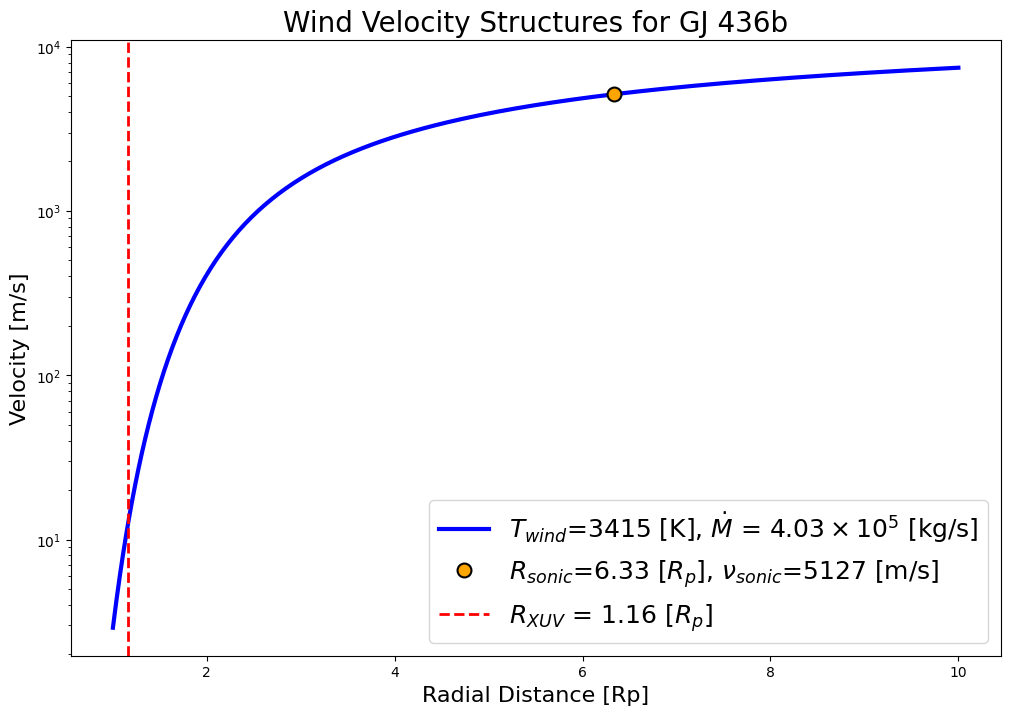

In [27]:
plt.figure(figsize=(12, 8))

# velocity profile
m_base, m_exp = f"{Mdot:.2e}".split('e')
mdot_formatted = fr"${m_base} \times 10^{{{int(m_exp)}}}$"

plt.plot(r_range/rp, v_profile, color='blue', 
         label=fr'$T_{{wind}}$={round(T_wind)} [K], $\dot{{M}}$ = {mdot_formatted} [kg/s]', 
         linewidth=3, alpha=1)

# sonic point and sonic speed
plt.plot(rs_wind/rp, vs_wind, 'o', markersize=10, color='orange', markeredgecolor='black', markeredgewidth=1.5, label=fr'$R_{{sonic}}$={round(rs_wind/rp,2)} [$R_p$], $\nu_{{sonic}}$={round(vs_wind)} [m/s]')

# RXUV line
plt.axvline(rXUV/rp, color='red', linestyle='--', linewidth=2, 
            label=fr'$R_{{XUV}}$ = {round(rXUV/rp, 2)} [$R_p$]')

plt.title('Wind Velocity Structures for GJ 436b', fontsize=20)
plt.yscale('log')
plt.xlabel(r'Radial Distance [Rp]', fontsize=16)
plt.ylabel(r'Velocity [m/s]', fontsize=16)
plt.legend(fontsize=18)
plt.show()

In [28]:
# Calculate density using mass conservation: rho(r) = Mdot / (4 * pi * r^2 * v(r))
# Mdot is the self-consistent mass-loss rate from solve_atmosphere function

rho_profile = Mdot / (4 * np.pi * r_range**2 * v_profile)
rhos_wind = Mdot / (4 * np.pi * rs_wind**2 * vs_wind)

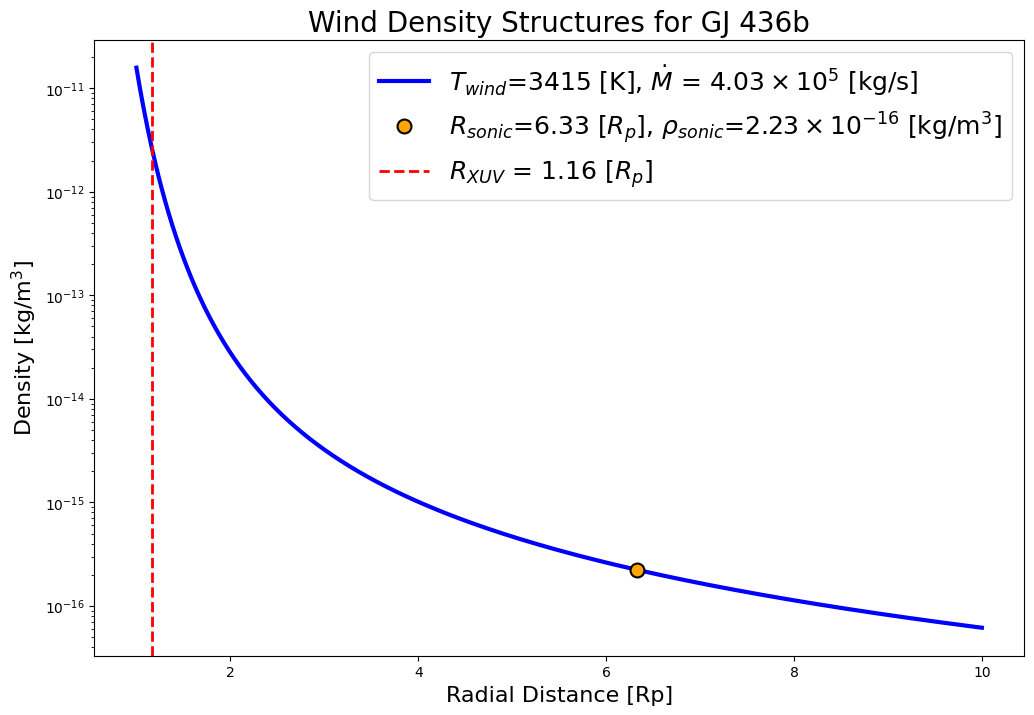

In [29]:
plt.figure(figsize=(12, 8))

# velocity profile
m_base, m_exp = f"{Mdot:.2e}".split('e')
mdot_formatted = fr"${m_base} \times 10^{{{int(m_exp)}}}$"

plt.plot(r_range/rp, rho_profile, color='blue', 
         label=fr'$T_{{wind}}$={round(T_wind)} [K], $\dot{{M}}$ = {mdot_formatted} [kg/s]', 
         linewidth=3, alpha=1)

# sonic point and sonic speed
base, exp = f"{rhos_wind:.2e}".split('e')
rhos_formatted = fr"${base} \times 10^{{{int(exp)}}}$"

plt.plot(rs_wind/rp, rhos_wind, 'o', markersize=10, color='orange', markeredgecolor='black', markeredgewidth=1.5, label=fr'$R_{{sonic}}$={round(rs_wind/rp,2)} [$R_p$], $\rho_{{sonic}}$={rhos_formatted} [kg/m$^3$]')

# RXUV line
plt.axvline(rXUV/rp, color='red', linestyle='--', linewidth=2, 
            label=fr'$R_{{XUV}}$ = {round(rXUV/rp, 2)} [$R_p$]')

plt.title('Wind Density Structures for GJ 436b', fontsize=20)
plt.yscale('log')
plt.xlabel(r'Radial Distance [Rp]', fontsize=16)
plt.ylabel(r'Density [kg/m$^3$]', fontsize=16)
plt.legend(fontsize=18)
plt.show()

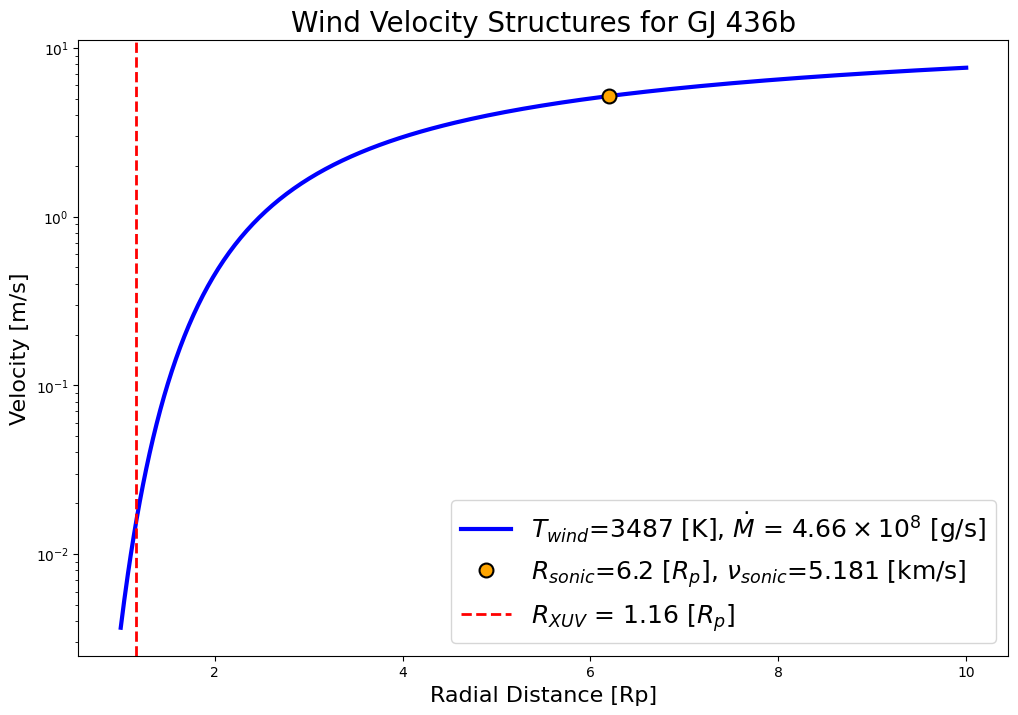

In [33]:
Mdot = Mdot * 1e3  # convert to g/s

plt.figure(figsize=(12, 8))

# velocity profile
m_base, m_exp = f"{Mdot:.2e}".split('e')
mdot_formatted = fr"${m_base} \times 10^{{{int(m_exp)}}}$"

plt.plot(R_range/Rp, v_profile/1000, color='blue', 
         label=fr'$T_{{wind}}$={round(T_wind)} [K], $\dot{{M}}$ = {mdot_formatted} [g/s]', 
         linewidth=3, alpha=1)

# sonic point and sonic speed
plt.plot(Rs_wind/Rp, vs_wind/1000, 'o', markersize=10, color='orange', markeredgecolor='black', markeredgewidth=1.5, label=fr'$R_{{sonic}}$={round(Rs_wind/Rp,2)} [$R_p$], $\nu_{{sonic}}$={round(vs_wind)/1000} [km/s]')

# RXUV line
plt.axvline(RXUV/Rp, color='red', linestyle='--', linewidth=2, 
            label=fr'$R_{{XUV}}$ = {round(RXUV/Rp, 2)} [$R_p$]')

plt.title('Wind Velocity Structures for GJ 436b', fontsize=20)
plt.yscale('log')
plt.xlabel(r'Radial Distance [Rp]', fontsize=16)
plt.ylabel(r'Velocity [m/s]', fontsize=16)
plt.legend(fontsize=18)
plt.show()

In [43]:
# Calculate density using mass conservation: rho(r) = Mdot / (4 * pi * r^2 * v(r))
# Mdot is the self-consistent mass-loss rate from solve_atmosphere function

rho_profile = Mdot / (4 * np.pi * R_range**2 * v_profile)/1000
rhos_wind = Mdot / (4 * np.pi * Rs_wind**2 * vs_wind)/1000

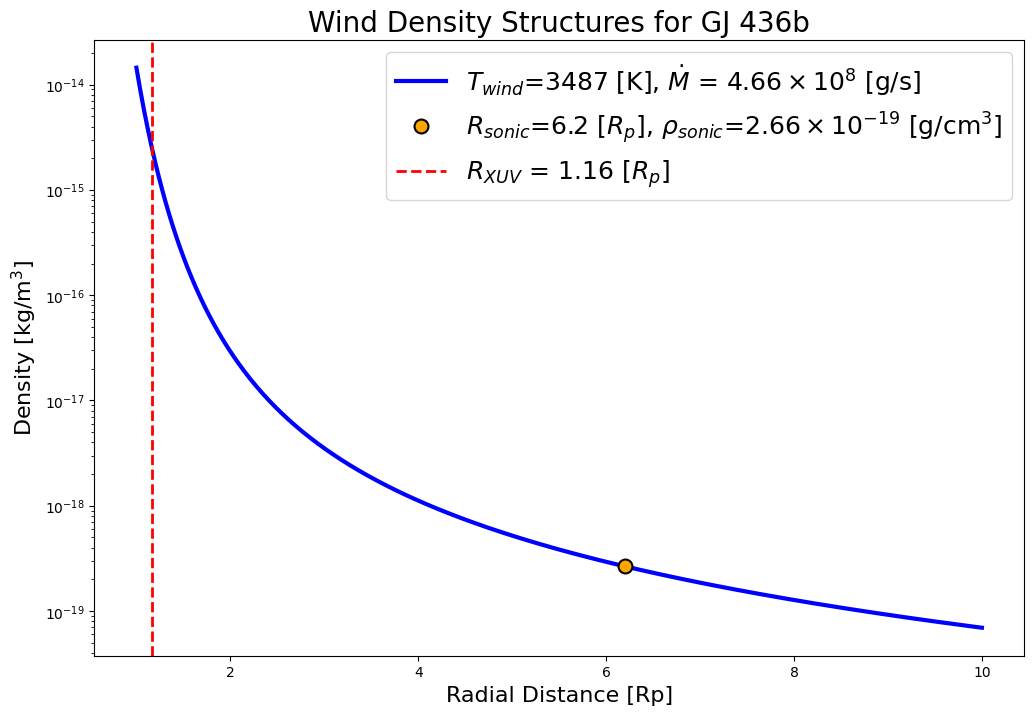

In [ ]:
plt.figure(figsize=(12, 8))

# velocity profile
m_base, m_exp = f"{Mdot:.2e}".split('e')
mdot_formatted = fr"${m_base} \times 10^{{{int(m_exp)}}}$"

plt.plot(R_range/Rp, rho_profile, color='blue', 
         label=fr'$T_{{wind}}$={round(T_wind)} [K], $\dot{{M}}$ = {mdot_formatted} [g/s]', 
         linewidth=3, alpha=1)

# sonic point and sonic speed
base, exp = f"{rhos_wind:.2e}".split('e')
rhos_formatted = fr"${base} \times 10^{{{int(exp)}}}$"

plt.plot(Rs_wind/Rp, rhos_wind, 'o', markersize=10, color='orange', markeredgecolor='black', markeredgewidth=1.5, label=fr'$R_{{sonic}}$={round(Rs_wind/Rp,2)} [$R_p$], $\rho_{{sonic}}$={rhos_formatted} [g/cm$^3$]')

# RXUV line
plt.axvline(RXUV/Rp, color='red', linestyle='--', linewidth=2, 
            label=fr'$R_{{XUV}}$ = {round(RXUV/Rp, 2)} [$R_p$]')

plt.title('Wind Density Structures for GJ 436b', fontsize=20)
plt.yscale('log')
plt.xlabel(r'Radial Distance [Rp]', fontsize=16)
plt.ylabel(r'Density [kg/m$^3$]', fontsize=16)
plt.legend(fontsize=18)
plt.show()